### Import library and model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import random

### Import, Scale and Split Dataset

In [2]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('..\Dataset\EUR.csv')
 # GBP - VND
gbp = pd.read_csv("..\Dataset\GBP.csv")
 # JPY - VND
jpy = pd.read_csv("..\Dataset\JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

### MinMaxScaler

In [3]:
# Scaler model
scaler=MinMaxScaler(feature_range=(0,1))

### Standardizate function

In [4]:
# Function to standardizate the data
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

### Prepare data

In [5]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

### Forecast

In [6]:
# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test, time_step):
    x_input = test[len(test)-time_step:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    n_steps=time_step
    i=0
    while(i<=90):
        if(len(temp_input)>time_step):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1,-1)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i=i+1
        else:
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i=i+1
    return forecast30, forecast60, forecast90

### Visualize

In [7]:
# Function to visualize the model
def visualize_MLP(model, train, test, pre_test, f3, f6, f9, time_step):
    # set index
    # set train, test index
    index = pd.date_range(start='3/1/2019', end='6/1/2024', freq='d')
    # set forecast index
    forecast_index = pd.date_range(start='6/1/2024', periods=91, freq='d')
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(index[:len(train)], scaler.inverse_transform(train))
    plt.plot(index[len(train):], scaler.inverse_transform(test))
    plt.plot(index[len(train)+time_step:],scaler.inverse_transform(pre_test))
    plt.plot(forecast_index[:31], scaler.inverse_transform(f3))
    plt.plot(forecast_index[31:61], scaler.inverse_transform(f6))
    plt.plot(forecast_index[61:], scaler.inverse_transform(f9))
    plt.title('MLP Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','TestPred','Forecast 30 days next','Forecast 60 days next','Forecast 90 days next'])
    plt.show()

### Evaluate

In [8]:
# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE(%) =',mape)
    print('MAE =',mae)

### Set seed

- Ensure that your model is always initialized and trained with the same random seed (đảm bảo rằng mô hình của bạn sẽ luôn được khởi tạo và huấn luyện với cùng một chuỗi số ngẫu nhiên => cùng một kết quả mỗi khi chạy lại chương trình)

- Ensure that differences in results are not due to differences in random numbers but rather due to differences in the nature of the models. (đảm bảo rằng sự khác biệt trong kết quả không phải do sự khác biệt trong số ngẫu nhiên mà do sự khác biệt trong bản chất của các mô hình)

### Implement

In [14]:
def implement_MLP(train, test):
    # set seed
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)
    
    # Time step
    time_step = 40
    
    # Convert train and test data
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    
    # Define MLP model
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=time_step))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit model
    model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=0)
    
    # Predict test data
    pre_test = model.predict(X_test)
    
    # Forecast next 30, 60, 90 days
    forecast30, forecast60, forecast90 = forecast_days(model, test, time_step)
    
    # Visualize model
    visualize_MLP(model, train, test, pre_test, forecast30, forecast60, forecast90, time_step)

    # Standardizate
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accurancy
    evaluate(pre_test, test[time_step:])

# EUR - VND


In [15]:
# Scale data
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
 ## case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
 ## case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.8655751]
41
1 day input [0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.86557508]
1 day output [[0.8643916]]
2 day input [0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.86557508 0.86439162]
2 

17 day output [[0.91723484]]
18 day input [0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.86557508 0.86439162
 0.87502503 0.882734   0.88166803 0.88082516 0.88987619 0.89063334
 0.89203328 0.89116096 0.90201545 0.90351367 0.89880478 0.90213984
 0.91405064 0.91942281 0.92074043 0.91723484]
18 day output [[0.92752016]]
19 day input [0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.86557508 0.86439162 0.87502503
 0.882734   0.88166803 0.88082516 0.88987619 0.89063334 0.89203328
 0.89116096 0.90201545 0.90351367 0.89880478 0.90213984 0.91405064
 0.91942281 0.92074043 0.91723484 0.92752016]
19 day output [[0.93

34 day output [[0.9835176]]
35 day input [0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.86557508
 0.86439162 0.87502503 0.882734   0.88166803 0.88082516 0.88987619
 0.89063334 0.89203328 0.89116096 0.90201545 0.90351367 0.89880478
 0.90213984 0.91405064 0.91942281 0.92074043 0.91723484 0.92752016
 0.93166357 0.93458295 0.93316281 0.94113499 0.94802427 0.94743329
 0.94602937 0.95866418 0.96195447 0.96285504 0.96202725 0.96919101
 0.97773176 0.97573352 0.97439307 0.98351759]
35 day output [[0.9914601]]
36 day input [0.87267576 0.85567558 0.86683195 0.86683195 0.86557508 0.86439162
 0.87502503 0.882734   0.88166803 0.88082516 0.88987619 0.89063334
 0.89203328 0.89116096 0.90201545 0.90351367 0.89880478 0.90213984
 0.91405064 0.91942281 0.92074043 0.91723484 0.92752016 0.93166357
 0.93458295 0.93316281 0.94113499 0.94802427 0.94743329 0.94602937
 0.95866418 0.96195447 0.96285504 0.96202725 0.96919101 0.97773176
 0.97573352 0.97439307 0.98351759 0.99146008]
36 day output [[0.9915

52 day output [[1.047862]]
53 day input [0.90213984 0.91405064 0.91942281 0.92074043 0.91723484 0.92752016
 0.93166357 0.93458295 0.93316281 0.94113499 0.94802427 0.94743329
 0.94602937 0.95866418 0.96195447 0.96285504 0.96202725 0.96919101
 0.97773176 0.97573352 0.97439307 0.98351759 0.99146008 0.99157059
 0.98997515 0.99933404 1.00586259 1.00353825 1.00506032 1.01314986
 1.01981616 1.01836526 1.01716912 1.02750778 1.03490186 1.03310692
 1.03305745 1.04097438 1.04966938 1.04786205]
53 day output [[1.047916]]
54 day input [0.91405064 0.91942281 0.92074043 0.91723484 0.92752016 0.93166357
 0.93458295 0.93316281 0.94113499 0.94802427 0.94743329 0.94602937
 0.95866418 0.96195447 0.96285504 0.96202725 0.96919101 0.97773176
 0.97573352 0.97439307 0.98351759 0.99146008 0.99157059 0.98997515
 0.99933404 1.00586259 1.00353825 1.00506032 1.01314986 1.01981616
 1.01836526 1.01716912 1.02750778 1.03490186 1.03310692 1.03305745
 1.04097438 1.04966938 1.04786205 1.04791605]
54 day output [[1.056381

70 day output [[1.1186998]]
71 day input [0.97773176 0.97573352 0.97439307 0.98351759 0.99146008 0.99157059
 0.98997515 0.99933404 1.00586259 1.00353825 1.00506032 1.01314986
 1.01981616 1.01836526 1.01716912 1.02750778 1.03490186 1.03310692
 1.03305745 1.04097438 1.04966938 1.04786205 1.04791605 1.05638134
 1.06340992 1.06356013 1.06370771 1.07076573 1.08029842 1.07851768
 1.07859671 1.08703673 1.09542322 1.09475386 1.09418356 1.10252976
 1.11160553 1.11089385 1.11112607 1.11869979]
71 day output [[1.128103]]
72 day input [0.97573352 0.97439307 0.98351759 0.99146008 0.99157059 0.98997515
 0.99933404 1.00586259 1.00353825 1.00506032 1.01314986 1.01981616
 1.01836526 1.01716912 1.02750778 1.03490186 1.03310692 1.03305745
 1.04097438 1.04966938 1.04786205 1.04791605 1.05638134 1.06340992
 1.06356013 1.06370771 1.07076573 1.08029842 1.07851768 1.07859671
 1.08703673 1.09542322 1.09475386 1.09418356 1.10252976 1.11160553
 1.11089385 1.11112607 1.11869979 1.12810302]
72 day output [[1.12777

89 day output [[1.1967788]]
90 day input [1.04097438 1.04966938 1.04786205 1.04791605 1.05638134 1.06340992
 1.06356013 1.06370771 1.07076573 1.08029842 1.07851768 1.07859671
 1.08703673 1.09542322 1.09475386 1.09418356 1.10252976 1.11160553
 1.11089385 1.11112607 1.11869979 1.12810302 1.12777972 1.12680709
 1.13597953 1.14495981 1.14404833 1.14410448 1.15242326 1.1622411
 1.16163361 1.16108072 1.16988051 1.17918432 1.17951941 1.17879605
 1.1870532  1.19722712 1.1969918  1.19677877]
90 day output [[1.2054802]]


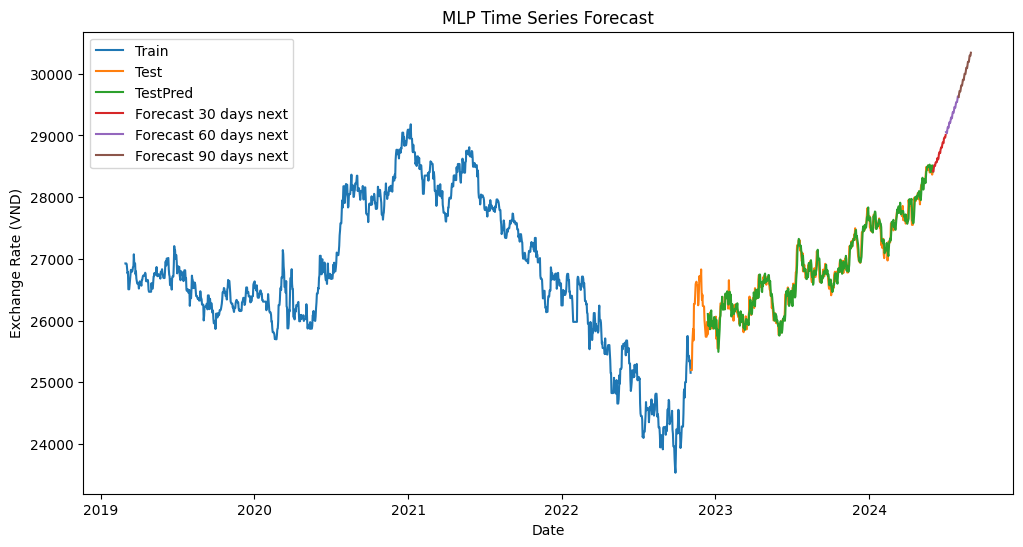

RMSE = 109.43684026810523
MAPE(%) = 0.30814207854851555
MAE = 82.58250859958028


In [16]:
implement_MLP(train_eur_1_sc, test_eur_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0.8597967]
41
1 day input [0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.8597967 ]
1 day output [[0.8575935]]
2 day input [0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.8597967  0.85759348]
2 

17 day output [[0.8222939]]
18 day input [0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.8597967  0.85759348
 0.85724431 0.86224252 0.8552438  0.85061276 0.85288846 0.84519929
 0.84348708 0.83679241 0.83890033 0.84088898 0.82892227 0.82834142
 0.83086181 0.83152223 0.82891309 0.82229388]
18 day output [[0.82193285]]
19 day input [0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.8597967  0.85759348 0.85724431
 0.86224252 0.8552438  0.85061276 0.85288846 0.84519929 0.84348708
 0.83679241 0.83890033 0.84088898 0.82892227 0.82834142 0.83086181
 0.83152223 0.82891309 0.82229388 0.82193285]
19 day output [[0.819

34 day output [[0.78654134]]
35 day input [0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.8597967
 0.85759348 0.85724431 0.86224252 0.8552438  0.85061276 0.85288846
 0.84519929 0.84348708 0.83679241 0.83890033 0.84088898 0.82892227
 0.82834142 0.83086181 0.83152223 0.82891309 0.82229388 0.82193285
 0.8198204  0.81484699 0.81233633 0.81022191 0.81167537 0.80600417
 0.79927838 0.80468321 0.80254716 0.79915261 0.7954722  0.79173815
 0.79326165 0.78991026 0.78350836 0.78654134]
35 day output [[0.7843618]]
36 day input [0.87267576 0.85567558 0.86683195 0.86683195 0.8597967  0.85759348
 0.85724431 0.86224252 0.8552438  0.85061276 0.85288846 0.84519929
 0.84348708 0.83679241 0.83890033 0.84088898 0.82892227 0.82834142
 0.83086181 0.83152223 0.82891309 0.82229388 0.82193285 0.8198204
 0.81484699 0.81233633 0.81022191 0.81167537 0.80600417 0.79927838
 0.80468321 0.80254716 0.79915261 0.7954722  0.79173815 0.79326165
 0.78991026 0.78350836 0.78654134 0.78436178]
36 day output [[0.78140

52 day output [[0.746708]]
53 day input [0.82834142 0.83086181 0.83152223 0.82891309 0.82229388 0.82193285
 0.8198204  0.81484699 0.81233633 0.81022191 0.81167537 0.80600417
 0.79927838 0.80468321 0.80254716 0.79915261 0.7954722  0.79173815
 0.79326165 0.78991026 0.78350836 0.78654134 0.78436178 0.78140247
 0.77761453 0.77561647 0.77743357 0.77047348 0.76679003 0.76882535
 0.76545382 0.76482099 0.75939661 0.75813538 0.76055956 0.75444037
 0.75229287 0.75079936 0.74886841 0.74670798]
53 day output [[0.74077165]]
54 day input [0.83086181 0.83152223 0.82891309 0.82229388 0.82193285 0.8198204
 0.81484699 0.81233633 0.81022191 0.81167537 0.80600417 0.79927838
 0.80468321 0.80254716 0.79915261 0.7954722  0.79173815 0.79326165
 0.78991026 0.78350836 0.78654134 0.78436178 0.78140247 0.77761453
 0.77561647 0.77743357 0.77047348 0.76679003 0.76882535 0.76545382
 0.76482099 0.75939661 0.75813538 0.76055956 0.75444037 0.75229287
 0.75079936 0.74886841 0.74670798 0.74077165]
54 day output [[0.74215

70 day output [[0.70698965]]
71 day input [0.79326165 0.78991026 0.78350836 0.78654134 0.78436178 0.78140247
 0.77761453 0.77561647 0.77743357 0.77047348 0.76679003 0.76882535
 0.76545382 0.76482099 0.75939661 0.75813538 0.76055956 0.75444037
 0.75229287 0.75079936 0.74886841 0.74670798 0.74077165 0.74215317
 0.74098748 0.73663175 0.7352109  0.73157275 0.73217416 0.72991347
 0.72348374 0.72497416 0.72235674 0.71902376 0.71710885 0.71369737
 0.71465462 0.71105385 0.70630515 0.70698965]
71 day output [[0.7036252]]
72 day input [0.78991026 0.78350836 0.78654134 0.78436178 0.78140247 0.77761453
 0.77561647 0.77743357 0.77047348 0.76679003 0.76882535 0.76545382
 0.76482099 0.75939661 0.75813538 0.76055956 0.75444037 0.75229287
 0.75079936 0.74886841 0.74670798 0.74077165 0.74215317 0.74098748
 0.73663175 0.7352109  0.73157275 0.73217416 0.72991347 0.72348374
 0.72497416 0.72235674 0.71902376 0.71710885 0.71369737 0.71465462
 0.71105385 0.70630515 0.70698965 0.7036252 ]
72 day output [[0.701

88 day output [[0.66615283]]
89 day input [0.75229287 0.75079936 0.74886841 0.74670798 0.74077165 0.74215317
 0.74098748 0.73663175 0.7352109  0.73157275 0.73217416 0.72991347
 0.72348374 0.72497416 0.72235674 0.71902376 0.71710885 0.71369737
 0.71465462 0.71105385 0.70630515 0.70698965 0.7036252  0.70195019
 0.69833273 0.69513106 0.69684076 0.69200903 0.68884128 0.68860471
 0.68516195 0.6843496  0.6797834  0.677692   0.67796606 0.67298269
 0.67122334 0.66882652 0.66703421 0.66615283]
89 day output [[0.6604546]]
90 day input [0.75079936 0.74886841 0.74670798 0.74077165 0.74215317 0.74098748
 0.73663175 0.7352109  0.73157275 0.73217416 0.72991347 0.72348374
 0.72497416 0.72235674 0.71902376 0.71710885 0.71369737 0.71465462
 0.71105385 0.70630515 0.70698965 0.7036252  0.70195019 0.69833273
 0.69513106 0.69684076 0.69200903 0.68884128 0.68860471 0.68516195
 0.6843496  0.6797834  0.677692   0.67796606 0.67298269 0.67122334
 0.66882652 0.66703421 0.66615283 0.66045457]
90 day output [[0.660

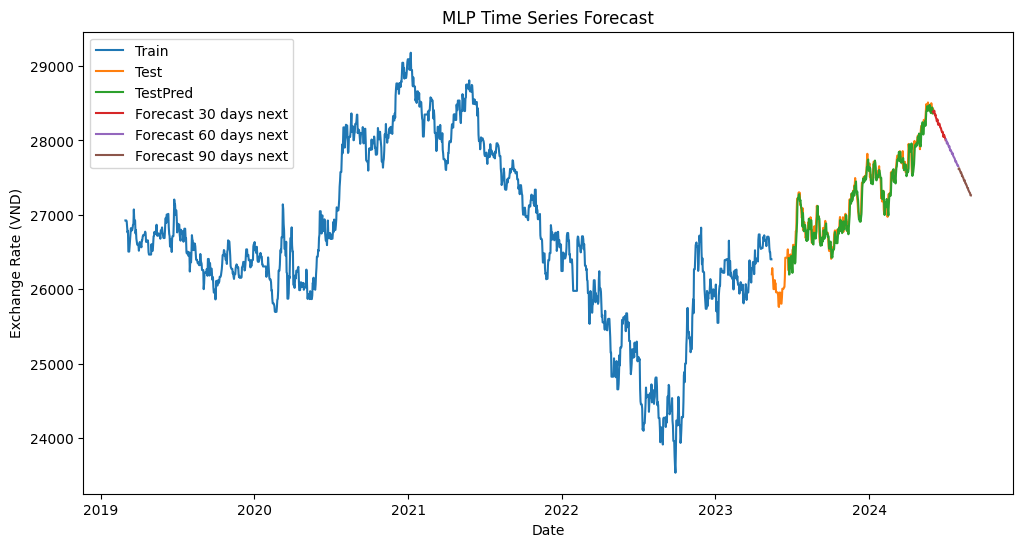

RMSE = 103.59407589690663
MAPE(%) = 0.287511074206996
MAE = 78.28086391715134


In [17]:
implement_MLP(train_eur_2_sc, test_eur_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[0.84901655]
41
1 day input [0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.84901655]
1 day output [[0.83997923]]
2 day input [0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.84901655 0.83997923]
2 

17 day output [[0.7019883]]
18 day input [0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.84901655 0.83997923
 0.83434641 0.8325696  0.81804788 0.80557865 0.80210495 0.7891168
 0.77926666 0.7675249  0.7648688  0.75836664 0.7394312  0.73223114
 0.73144758 0.72552496 0.71587449 0.70198828]
18 day output [[0.699154]]
19 day input [0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.84901655 0.83997923 0.83434641
 0.8325696  0.81804788 0.80557865 0.80210495 0.7891168  0.77926666
 0.7675249  0.7648688  0.75836664 0.7394312  0.73223114 0.73144758
 0.72552496 0.71587449 0.70198828 0.69915402]
19 day output [[0.692654

37 day output [[0.56647384]]
38 day input [0.86683195 0.86683195 0.84901655 0.83997923 0.83434641 0.8325696
 0.81804788 0.80557865 0.80210495 0.7891168  0.77926666 0.7675249
 0.7648688  0.75836664 0.7394312  0.73223114 0.73144758 0.72552496
 0.71587449 0.70198828 0.69915402 0.69265473 0.68221253 0.67220771
 0.66627872 0.66220754 0.65051085 0.63800532 0.64075398 0.63389277
 0.62334108 0.6144731  0.60922372 0.60834366 0.59894496 0.58594954
 0.58533204 0.58402824 0.57620293 0.56647384]
38 day output [[0.5642503]]
39 day input [0.86683195 0.84901655 0.83997923 0.83434641 0.8325696  0.81804788
 0.80557865 0.80210495 0.7891168  0.77926666 0.7675249  0.7648688
 0.75836664 0.7394312  0.73223114 0.73144758 0.72552496 0.71587449
 0.70198828 0.69915402 0.69265473 0.68221253 0.67220771 0.66627872
 0.66220754 0.65051085 0.63800532 0.64075398 0.63389277 0.62334108
 0.6144731  0.60922372 0.60834366 0.59894496 0.58594954 0.58533204
 0.58402824 0.57620293 0.56647384 0.56425029]
39 day output [[0.563569

57 day output [[0.46176612]]
58 day input [0.69915402 0.69265473 0.68221253 0.67220771 0.66627872 0.66220754
 0.65051085 0.63800532 0.64075398 0.63389277 0.62334108 0.6144731
 0.60922372 0.60834366 0.59894496 0.58594954 0.58533204 0.58402824
 0.57620293 0.56647384 0.56425029 0.56356943 0.55288875 0.54499733
 0.54510319 0.54153371 0.53356218 0.52287853 0.52153301 0.52202547
 0.51143837 0.50315887 0.5007863  0.49843308 0.49062163 0.48027691
 0.48012376 0.47715357 0.46829849 0.46176612]
58 day output [[0.45772558]]
59 day input [0.69265473 0.68221253 0.67220771 0.66627872 0.66220754 0.65051085
 0.63800532 0.64075398 0.63389277 0.62334108 0.6144731  0.60922372
 0.60834366 0.59894496 0.58594954 0.58533204 0.58402824 0.57620293
 0.56647384 0.56425029 0.56356943 0.55288875 0.54499733 0.54510319
 0.54153371 0.53356218 0.52287853 0.52153301 0.52202547 0.51143837
 0.50315887 0.5007863  0.49843308 0.49062163 0.48027691 0.48012376
 0.47715357 0.46829849 0.46176612 0.45772558]
59 day output [[0.457

77 day output [[0.3728393]]
78 day input [0.56425029 0.56356943 0.55288875 0.54499733 0.54510319 0.54153371
 0.53356218 0.52287853 0.52153301 0.52202547 0.51143837 0.50315887
 0.5007863  0.49843308 0.49062163 0.48027691 0.48012376 0.47715357
 0.46829849 0.46176612 0.45772558 0.45793015 0.45013735 0.43969163
 0.44012073 0.43808708 0.43046233 0.42306077 0.41966534 0.42029345
 0.41280377 0.40492058 0.40377986 0.40194154 0.39642313 0.38781336
 0.38603592 0.38771859 0.38002545 0.3728393 ]
78 day output [[0.37170592]]
79 day input [0.56356943 0.55288875 0.54499733 0.54510319 0.54153371 0.53356218
 0.52287853 0.52153301 0.52202547 0.51143837 0.50315887 0.5007863
 0.49843308 0.49062163 0.48027691 0.48012376 0.47715357 0.46829849
 0.46176612 0.45772558 0.45793015 0.45013735 0.43969163 0.44012073
 0.43808708 0.43046233 0.42306077 0.41966534 0.42029345 0.41280377
 0.40492058 0.40377986 0.40194154 0.39642313 0.38781336 0.38603592
 0.38771859 0.38002545 0.3728393  0.37170592]
79 day output [[0.3715

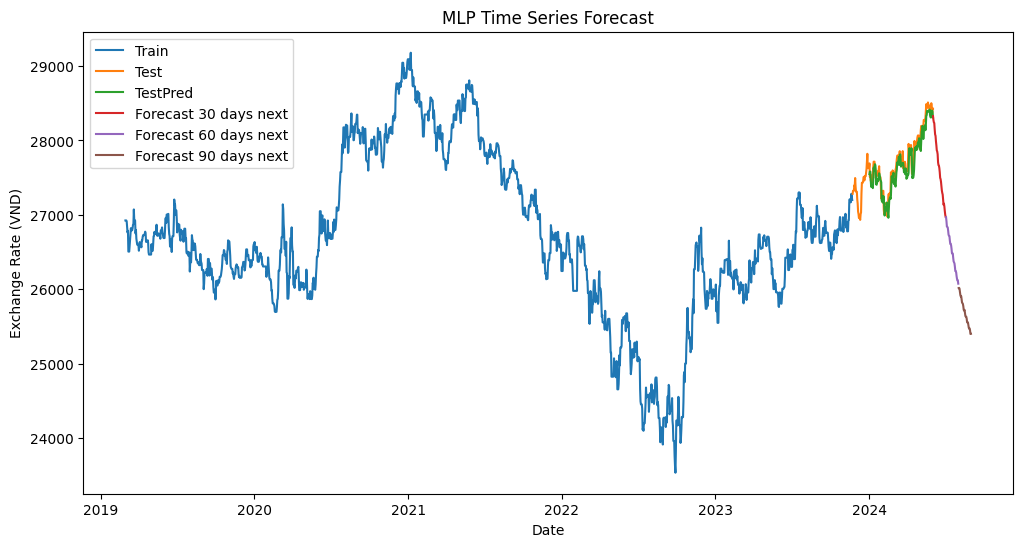

RMSE = 119.30717070683035
MAPE(%) = 0.3549468493290934
MAE = 98.53298468338825


In [18]:
implement_MLP(train_eur_3_sc, test_eur_3_sc)

# GBP - VND

In [19]:
# Scale data
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
 ## case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
 ## case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.9741893]
41
1 day input [0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.97418928]
1 day output [[0.9768466]]
2 day input [0.88970789 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424
 0.87878788 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991
 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.97418928 0.97684658]

17 day output [[1.0901736]]
18 day input [0.90745291 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345
 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.98826099 0.97229047 0.97147147 0.97147147 0.97418928 0.97684658
 0.98757309 0.99671    0.99995512 1.00580835 1.01793909 1.021456
 1.02452469 1.0310142  1.04765487 1.05315673 1.05231202 1.05842829
 1.07364011 1.08474565 1.09116614 1.0901736 ]
18 day output [[1.1004927]]
19 day input [0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.97418928 0.97684658 0.98757309
 0.99671    0.99995512 1.00580835 1.01793909 1.021456   1.02452469
 1.0310142  1.04765487 1.05315673 1.05231202 1.05842829 1.07364011
 1.08474565 1.09116614 1.0901736  1.10049272]
19 day output [[1.107788

36 day output [[1.2225695]]
37 day input [0.97229047 0.97147147 0.97147147 0.97418928 0.97684658 0.98757309
 0.99671    0.99995512 1.00580835 1.01793909 1.021456   1.02452469
 1.0310142  1.04765487 1.05315673 1.05231202 1.05842829 1.07364011
 1.08474565 1.09116614 1.0901736  1.10049272 1.10778821 1.11428559
 1.11747658 1.12662446 1.1360569  1.14154434 1.14416242 1.15553713
 1.16300666 1.16700971 1.17067552 1.17972922 1.18979096 1.19254124
 1.19669855 1.20750833 1.21735001 1.22256947]
37 day output [[1.2270166]]
38 day input [0.97147147 0.97147147 0.97418928 0.97684658 0.98757309 0.99671
 0.99995512 1.00580835 1.01793909 1.021456   1.02452469 1.0310142
 1.04765487 1.05315673 1.05231202 1.05842829 1.07364011 1.08474565
 1.09116614 1.0901736  1.10049272 1.10778821 1.11428559 1.11747658
 1.12662446 1.1360569  1.14154434 1.14416242 1.15553713 1.16300666
 1.16700971 1.17067552 1.17972922 1.18979096 1.19254124 1.19669855
 1.20750833 1.21735001 1.22256947 1.22701657]
38 day output [[1.239185]]

55 day output [[1.3744572]]
56 day input [1.09116614 1.0901736  1.10049272 1.10778821 1.11428559 1.11747658
 1.12662446 1.1360569  1.14154434 1.14416242 1.15553713 1.16300666
 1.16700971 1.17067552 1.17972922 1.18979096 1.19254124 1.19669855
 1.20750833 1.21735001 1.22256947 1.22701657 1.23918498 1.24879837
 1.25106657 1.25683129 1.26926827 1.28026593 1.28380096 1.28716636
 1.30036831 1.31215799 1.31602621 1.3206749  1.33092451 1.34306777
 1.34799254 1.35285175 1.36365163 1.37445724]
56 day output [[1.3802376]]
57 day input [1.0901736  1.10049272 1.10778821 1.11428559 1.11747658 1.12662446
 1.1360569  1.14154434 1.14416242 1.15553713 1.16300666 1.16700971
 1.17067552 1.17972922 1.18979096 1.19254124 1.19669855 1.20750833
 1.21735001 1.22256947 1.22701657 1.23918498 1.24879837 1.25106657
 1.25683129 1.26926827 1.28026593 1.28380096 1.28716636 1.30036831
 1.31215799 1.31602621 1.3206749  1.33092451 1.34306777 1.34799254
 1.35285175 1.36365163 1.37445724 1.38023758]
57 day output [[1.3862

72 day output [[1.5189655]]
73 day input [1.19669855 1.20750833 1.21735001 1.22256947 1.22701657 1.23918498
 1.24879837 1.25106657 1.25683129 1.26926827 1.28026593 1.28380096
 1.28716636 1.30036831 1.31215799 1.31602621 1.3206749  1.33092451
 1.34306777 1.34799254 1.35285175 1.36365163 1.37445724 1.38023758
 1.38629138 1.39677358 1.40875351 1.41323197 1.41893995 1.43062556
 1.44236279 1.44776762 1.45282054 1.46488202 1.47757471 1.48261666
 1.48844635 1.50035369 1.51331663 1.51896548]
73 day output [[1.523869]]
74 day input [1.20750833 1.21735001 1.22256947 1.22701657 1.23918498 1.24879837
 1.25106657 1.25683129 1.26926827 1.28026593 1.28380096 1.28716636
 1.30036831 1.31215799 1.31602621 1.3206749  1.33092451 1.34306777
 1.34799254 1.35285175 1.36365163 1.37445724 1.38023758 1.38629138
 1.39677358 1.40875351 1.41323197 1.41893995 1.43062556 1.44236279
 1.44776762 1.45282054 1.46488202 1.47757471 1.48261666 1.48844635
 1.50035369 1.51331663 1.51896548 1.52386904]
74 day output [[1.53675

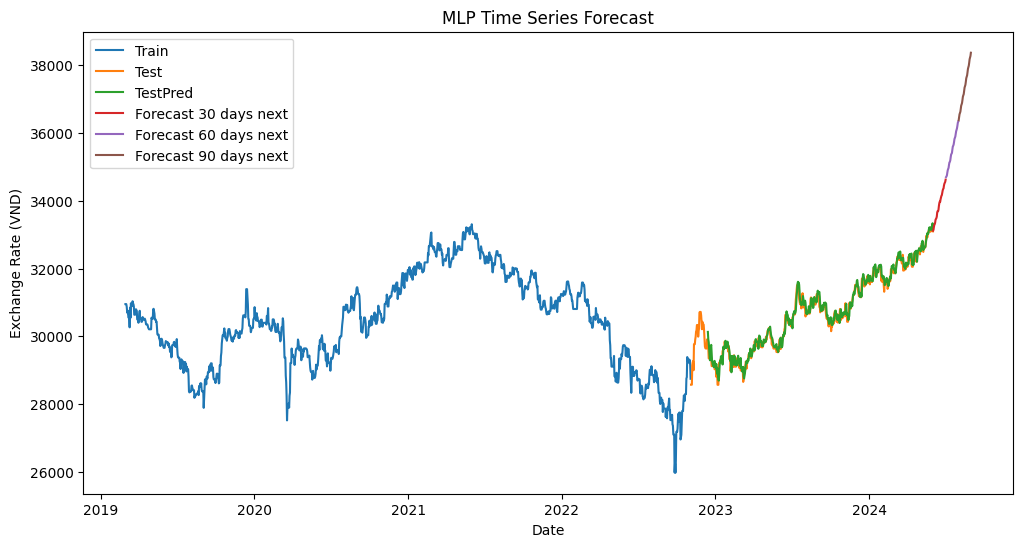

RMSE = 154.31052751753407
MAPE(%) = 0.38753084733719473
MAE = 118.591261223181


In [20]:
implement_MLP(train_gbp_1_sc, test_gbp_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.9731743]
41
1 day input [0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.97317427]
1 day output [[0.9743345]]
2 day input [0.88970789 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424
 0.87878788 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991
 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.97317427 0.97433448]

17 day output [[1.0108799]]
18 day input [0.90745291 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345
 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.98826099 0.97229047 0.97147147 0.97147147 0.97317427 0.97433448
 0.97868419 0.98118138 0.98254037 0.9819991  0.98729819 0.99046999
 0.9907577  0.9882732  0.99596959 0.99903101 0.99709147 0.99682766
 1.00450695 1.00800002 1.01162195 1.01087987]
18 day output [[1.0148057]]
19 day input [0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.97317427 0.97433448 0.97868419
 0.98118138 0.98254037 0.9819991  0.98729819 0.99046999 0.9907577
 0.9882732  0.99596959 0.99903101 0.99709147 0.99682766 1.00450695
 1.00800002 1.01162195 1.01087987 1.01480567]
19 day output [[1.01748

36 day output [[1.0629559]]
37 day input [0.97229047 0.97147147 0.97147147 0.97317427 0.97433448 0.97868419
 0.98118138 0.98254037 0.9819991  0.98729819 0.99046999 0.9907577
 0.9882732  0.99596959 0.99903101 0.99709147 0.99682766 1.00450695
 1.00800002 1.01162195 1.01087987 1.01480567 1.017483   1.02153289
 1.02184284 1.02600586 1.02971494 1.03221893 1.0326736  1.03726125
 1.04076052 1.0431093  1.04446495 1.04675007 1.05042052 1.05326807
 1.05388689 1.05699313 1.06094182 1.06295586]
37 day output [[1.0640227]]
38 day input [0.97147147 0.97147147 0.97317427 0.97433448 0.97868419 0.98118138
 0.98254037 0.9819991  0.98729819 0.99046999 0.9907577  0.9882732
 0.99596959 0.99903101 0.99709147 0.99682766 1.00450695 1.00800002
 1.01162195 1.01087987 1.01480567 1.017483   1.02153289 1.02184284
 1.02600586 1.02971494 1.03221893 1.0326736  1.03726125 1.04076052
 1.0431093  1.04446495 1.04675007 1.05042052 1.05326807 1.05388689
 1.05699313 1.06094182 1.06295586 1.06402266]
38 day output [[1.068150

53 day output [[1.1079512]]
54 day input [1.00450695 1.00800002 1.01162195 1.01087987 1.01480567 1.017483
 1.02153289 1.02184284 1.02600586 1.02971494 1.03221893 1.0326736
 1.03726125 1.04076052 1.0431093  1.04446495 1.04675007 1.05042052
 1.05326807 1.05388689 1.05699313 1.06094182 1.06295586 1.06402266
 1.0681504  1.07164299 1.07330549 1.0751847  1.07815599 1.08162057
 1.08459032 1.08582401 1.08818662 1.09260678 1.09519112 1.09668243
 1.09948337 1.10334313 1.10560453 1.10795116]
54 day output [[1.1106595]]
55 day input [1.00800002 1.01162195 1.01087987 1.01480567 1.017483   1.02153289
 1.02184284 1.02600586 1.02971494 1.03221893 1.0326736  1.03726125
 1.04076052 1.0431093  1.04446495 1.04675007 1.05042052 1.05326807
 1.05388689 1.05699313 1.06094182 1.06295586 1.06402266 1.0681504
 1.07164299 1.07330549 1.0751847  1.07815599 1.08162057 1.08459032
 1.08582401 1.08818662 1.09260678 1.09519112 1.09668243 1.09948337
 1.10334313 1.10560453 1.10795116 1.11065948]
55 day output [[1.1139868]

72 day output [[1.1619412]]
73 day input [1.05388689 1.05699313 1.06094182 1.06295586 1.06402266 1.0681504
 1.07164299 1.07330549 1.0751847  1.07815599 1.08162057 1.08459032
 1.08582401 1.08818662 1.09260678 1.09519112 1.09668243 1.09948337
 1.10334313 1.10560453 1.10795116 1.11065948 1.11398685 1.11675024
 1.11910915 1.12144113 1.12534285 1.1280576  1.12999594 1.13288236
 1.13653958 1.13893008 1.14140677 1.14425385 1.14747202 1.15028739
 1.15292418 1.15529752 1.15885067 1.16194117]
73 day output [[1.1641123]]
74 day input [1.05699313 1.06094182 1.06295586 1.06402266 1.0681504  1.07164299
 1.07330549 1.0751847  1.07815599 1.08162057 1.08459032 1.08582401
 1.08818662 1.09260678 1.09519112 1.09668243 1.09948337 1.10334313
 1.10560453 1.10795116 1.11065948 1.11398685 1.11675024 1.11910915
 1.12144113 1.12534285 1.1280576  1.12999594 1.13288236 1.13653958
 1.13893008 1.14140677 1.14425385 1.14747202 1.15028739 1.15292418
 1.15529752 1.15885067 1.16194117 1.16411233]
74 day output [[1.16674

89 day output [[1.2107801]]
90 day input [1.09948337 1.10334313 1.10560453 1.10795116 1.11065948 1.11398685
 1.11675024 1.11910915 1.12144113 1.12534285 1.1280576  1.12999594
 1.13288236 1.13653958 1.13893008 1.14140677 1.14425385 1.14747202
 1.15028739 1.15292418 1.15529752 1.15885067 1.16194117 1.16411233
 1.16674244 1.17046118 1.17317843 1.17566931 1.17851019 1.18173778
 1.18469357 1.18749213 1.19006228 1.19329906 1.19652212 1.19907105
 1.2017566  1.20523143 1.20818067 1.21078014]
90 day output [[1.2137926]]


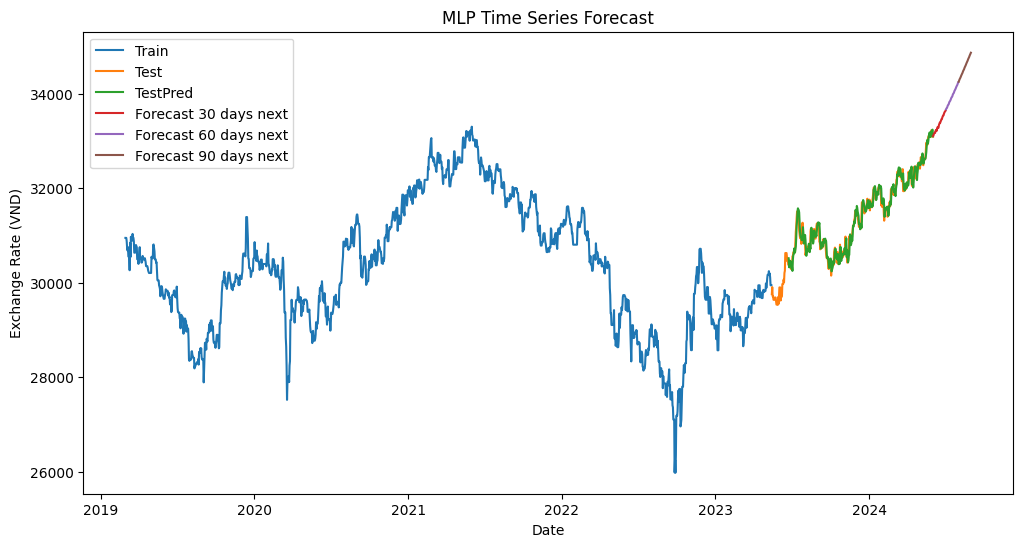

RMSE = 132.7291888467573
MAPE(%) = 0.31505215195734027
MAE = 98.78819381359023


In [21]:
implement_MLP(train_gbp_2_sc, test_gbp_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[0.9582366]
41
1 day input [0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.95823658]
1 day output [[0.9555089]]
2 day input [0.88970789 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424
 0.87878788 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991
 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.95823658 0.95550889]
2

18 day output [[0.85159963]]
19 day input [0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.95823658 0.95550889 0.94938183
 0.9483946  0.93565309 0.92705142 0.92689711 0.92291486 0.91499722
 0.90413809 0.89929849 0.89731258 0.8863706  0.88056326 0.87643814
 0.87205869 0.86652207 0.85804367 0.85159963]
19 day output [[0.8489076]]
20 day input [0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.95823658 0.95550889 0.94938183 0.9483946
 0.93565309 0.92705142 0.92689711 0.92291486 0.91499722 0.90413809
 0.89929849 0.89731258 0.8863706  0.88056326 0.87643814 0.87205869
 0.86652207 0.85804367 0.85159963 0.84890759]
20 day output [[0.8414

35 day output [[0.75035393]]
36 day input [0.98826099 0.97229047 0.97147147 0.97147147 0.95823658 0.95550889
 0.94938183 0.9483946  0.93565309 0.92705142 0.92689711 0.92291486
 0.91499722 0.90413809 0.89929849 0.89731258 0.8863706  0.88056326
 0.87643814 0.87205869 0.86652207 0.85804367 0.85159963 0.84890759
 0.84146124 0.83484834 0.82695031 0.82483327 0.81773573 0.80754614
 0.80222869 0.7991659  0.79257202 0.78509343 0.77829456 0.77429545
 0.7691462  0.75914013 0.75332934 0.75035393]
36 day output [[0.7442817]]
37 day input [0.97229047 0.97147147 0.97147147 0.95823658 0.95550889 0.94938183
 0.9483946  0.93565309 0.92705142 0.92689711 0.92291486 0.91499722
 0.90413809 0.89929849 0.89731258 0.8863706  0.88056326 0.87643814
 0.87205869 0.86652207 0.85804367 0.85159963 0.84890759 0.84146124
 0.83484834 0.82695031 0.82483327 0.81773573 0.80754614 0.80222869
 0.7991659  0.79257202 0.78509343 0.77829456 0.77429545 0.7691462
 0.75914013 0.75332934 0.75035393 0.74428171]
37 day output [[0.7365

53 day output [[0.6535075]]
54 day input [0.87643814 0.87205869 0.86652207 0.85804367 0.85159963 0.84890759
 0.84146124 0.83484834 0.82695031 0.82483327 0.81773573 0.80754614
 0.80222869 0.7991659  0.79257202 0.78509343 0.77829456 0.77429545
 0.7691462  0.75914013 0.75332934 0.75035393 0.74428171 0.73658931
 0.72942036 0.72741997 0.72147739 0.71431148 0.70898807 0.70455879
 0.70030504 0.69323707 0.6866619  0.68429345 0.67928731 0.67304236
 0.66743201 0.66365862 0.65976411 0.65350747]
54 day output [[0.64797837]]
55 day input [0.87205869 0.86652207 0.85804367 0.85159963 0.84890759 0.84146124
 0.83484834 0.82695031 0.82483327 0.81773573 0.80754614 0.80222869
 0.7991659  0.79257202 0.78509343 0.77829456 0.77429545 0.7691462
 0.75914013 0.75332934 0.75035393 0.74428171 0.73658931 0.72942036
 0.72741997 0.72147739 0.71431148 0.70898807 0.70455879 0.70030504
 0.69323707 0.6866619  0.68429345 0.67928731 0.67304236 0.66743201
 0.66365862 0.65976411 0.65350747 0.64797837]
55 day output [[0.6447

71 day output [[0.5757658]]
72 day input [0.7691462  0.75914013 0.75332934 0.75035393 0.74428171 0.73658931
 0.72942036 0.72741997 0.72147739 0.71431148 0.70898807 0.70455879
 0.70030504 0.69323707 0.6866619  0.68429345 0.67928731 0.67304236
 0.66743201 0.66365862 0.65976411 0.65350747 0.64797837 0.6447261
 0.64038104 0.63552964 0.62916982 0.62579256 0.6228506  0.61715329
 0.61173612 0.60870731 0.60510463 0.6005469  0.59497815 0.59170926
 0.58888656 0.58413875 0.57925749 0.57576579]
72 day output [[0.57306343]]
73 day input [0.75914013 0.75332934 0.75035393 0.74428171 0.73658931 0.72942036
 0.72741997 0.72147739 0.71431148 0.70898807 0.70455879 0.70030504
 0.69323707 0.6866619  0.68429345 0.67928731 0.67304236 0.66743201
 0.66365862 0.65976411 0.65350747 0.64797837 0.6447261  0.64038104
 0.63552964 0.62916982 0.62579256 0.6228506  0.61715329 0.61173612
 0.60870731 0.60510463 0.6005469  0.59497815 0.59170926 0.58888656
 0.58413875 0.57925749 0.57576579 0.57306343]
73 day output [[0.5690

89 day output [[0.5144768]]
90 day input [0.66743201 0.66365862 0.65976411 0.65350747 0.64797837 0.6447261
 0.64038104 0.63552964 0.62916982 0.62579256 0.6228506  0.61715329
 0.61173612 0.60870731 0.60510463 0.6005469  0.59497815 0.59170926
 0.58888656 0.58413875 0.57925749 0.57576579 0.57306343 0.56908649
 0.56372654 0.56110489 0.55821723 0.55413365 0.54985183 0.54640442
 0.54395288 0.54047245 0.53587848 0.53299361 0.5303818  0.52720094
 0.52298939 0.51979494 0.51773924 0.51447678]
90 day output [[0.51055926]]


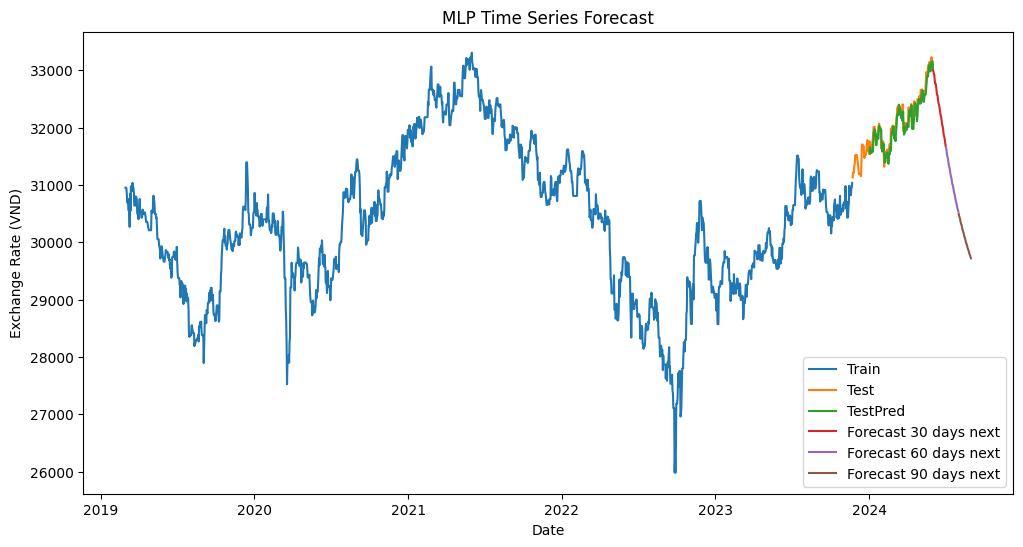

RMSE = 133.80781143014056
MAPE(%) = 0.33613301937927664
MAE = 108.0953176398026


In [22]:
implement_MLP(train_gbp_3_sc, test_gbp_3_sc)

# JPY - VND


In [23]:
# Scale data
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
 ## case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
 ## case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.01449679]
41
1 day input [0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01449679]
1 day output [[0.01299785]]
2 day input [0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.01449679 0.01299785]

17 day output [[0.02451993]]
18 day input [0.04596413 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119
 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.01449679 0.01299785
 0.02743779 0.03020975 0.01514306 0.01843423 0.02010265 0.01780972
 0.01052655 0.01392274 0.01764456 0.0226261  0.02052375 0.01995295
 0.02434768 0.02549206 0.02581279 0.02451993]
18 day output [[0.02454999]]
19 day input [0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01449679 0.01299785 0.02743779
 0.03020975 0.01514306 0.01843423 0.02010265 0.01780972 0.01052655
 0.01392274 0.01764456 0.0226261  0.02052375 0.01995295 0.02434768
 0.02549206 0.02581279 0.02451993 0.02454999]
19 day output [[0.0268

35 day output [[0.02299098]]
36 day input [0.02466368 0.02722614 0.02017937 0.02017937 0.01449679 0.01299785
 0.02743779 0.03020975 0.01514306 0.01843423 0.02010265 0.01780972
 0.01052655 0.01392274 0.01764456 0.0226261  0.02052375 0.01995295
 0.02434768 0.02549206 0.02581279 0.02451993 0.02454999 0.02680934
 0.02231508 0.02151331 0.02553676 0.02586845 0.02176028 0.02303648
 0.02612371 0.02780322 0.02325535 0.02240841 0.02808175 0.02705038
 0.01909882 0.01846652 0.02159478 0.02299098]
36 day output [[0.01902228]]
37 day input [0.02722614 0.02017937 0.02017937 0.01449679 0.01299785 0.02743779
 0.03020975 0.01514306 0.01843423 0.02010265 0.01780972 0.01052655
 0.01392274 0.01764456 0.0226261  0.02052375 0.01995295 0.02434768
 0.02549206 0.02581279 0.02451993 0.02454999 0.02680934 0.02231508
 0.02151331 0.02553676 0.02586845 0.02176028 0.02303648 0.02612371
 0.02780322 0.02325535 0.02240841 0.02808175 0.02705038 0.01909882
 0.01846652 0.02159478 0.02299098 0.01902228]
37 day output [[0.01

53 day output [[0.00831253]]
54 day input [0.02434768 0.02549206 0.02581279 0.02451993 0.02454999 0.02680934
 0.02231508 0.02151331 0.02553676 0.02586845 0.02176028 0.02303648
 0.02612371 0.02780322 0.02325535 0.02240841 0.02808175 0.02705038
 0.01909882 0.01846652 0.02159478 0.02299098 0.01902228 0.01445478
 0.01894476 0.02104968 0.01337975 0.01120731 0.01673378 0.01808123
 0.01324435 0.01199636 0.01513003 0.0159281  0.0111849  0.0095548
 0.01342539 0.01435393 0.00911998 0.00831253]
54 day output [[0.01221075]]
55 day input [0.02549206 0.02581279 0.02451993 0.02454999 0.02680934 0.02231508
 0.02151331 0.02553676 0.02586845 0.02176028 0.02303648 0.02612371
 0.02780322 0.02325535 0.02240841 0.02808175 0.02705038 0.01909882
 0.01846652 0.02159478 0.02299098 0.01902228 0.01445478 0.01894476
 0.02104968 0.01337975 0.01120731 0.01673378 0.01808123 0.01324435
 0.01199636 0.01513003 0.0159281  0.0111849  0.0095548  0.01342539
 0.01435393 0.00911998 0.00831253 0.01221075]
55 day output [[0.014

71 day output [[0.01474836]]
72 day input [0.01909882 0.01846652 0.02159478 0.02299098 0.01902228 0.01445478
 0.01894476 0.02104968 0.01337975 0.01120731 0.01673378 0.01808123
 0.01324435 0.01199636 0.01513003 0.0159281  0.0111849  0.0095548
 0.01342539 0.01435393 0.00911998 0.00831253 0.01221075 0.01454937
 0.00991653 0.00788703 0.0137356  0.01548284 0.00956877 0.00836484
 0.01280013 0.01556508 0.01019352 0.00673676 0.01223033 0.01510495
 0.0091202  0.00714881 0.01202828 0.01474836]
72 day output [[0.00923933]]
73 day input [0.01846652 0.02159478 0.02299098 0.01902228 0.01445478 0.01894476
 0.02104968 0.01337975 0.01120731 0.01673378 0.01808123 0.01324435
 0.01199636 0.01513003 0.0159281  0.0111849  0.0095548  0.01342539
 0.01435393 0.00911998 0.00831253 0.01221075 0.01454937 0.00991653
 0.00788703 0.0137356  0.01548284 0.00956877 0.00836484 0.01280013
 0.01556508 0.01019352 0.00673676 0.01223033 0.01510495 0.0091202
 0.00714881 0.01202828 0.01474836 0.00923933]
73 day output [[0.0061

89 day output [[-0.00112935]]
90 day input [ 1.34253856e-02  1.43539310e-02  9.11998004e-03  8.31252616e-03
  1.22107454e-02  1.45493653e-02  9.91652813e-03  7.88702536e-03
  1.37355998e-02  1.54828429e-02  9.56877321e-03  8.36484134e-03
  1.28001310e-02  1.55650768e-02  1.01935156e-02  6.73676003e-03
  1.22303329e-02  1.51049532e-02  9.12020262e-03  7.14881439e-03
  1.20282825e-02  1.47483554e-02  9.23932530e-03  6.14531990e-03
  1.03895757e-02  1.35270692e-02  7.87225552e-03  4.29621618e-03
  9.24321637e-03  1.19239725e-02  5.26306964e-03  2.28707935e-03
  6.83963951e-03  9.72779840e-03  3.79976863e-03  7.14999624e-05
  5.26542868e-03  8.33892263e-03  2.07437389e-03 -1.12935249e-03]
90 day output [[0.00284222]]


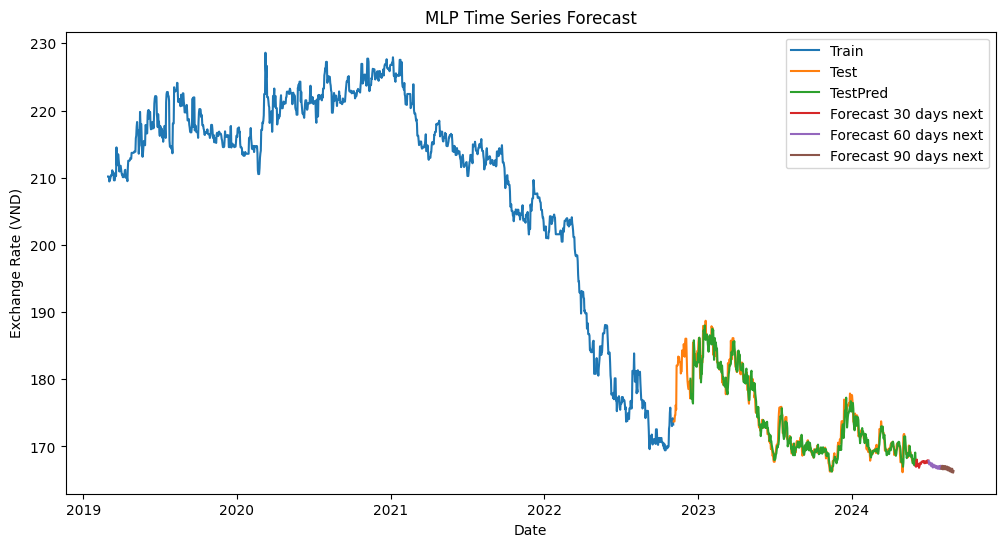

RMSE = 1.2147382764226422
MAPE(%) = 0.4838978585153535
MAE = 0.8504874329068771


In [24]:
implement_MLP(train_jpy_1_sc, test_jpy_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0.01970259]
41
1 day input [0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01970259]
1 day output [[0.01814365]]
2 day input [0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.01970259 0.01814365]

18 day output [[0.03573416]]
19 day input [0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01970259 0.01814365 0.03053298
 0.03378362 0.02707848 0.02355369 0.02632941 0.03081466 0.02375526
 0.02539529 0.03086115 0.03521026 0.03735856 0.0323059  0.04005612
 0.03967437 0.03895694 0.03737192 0.03573416]
19 day output [[0.03669211]]
20 day input [0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.01970259 0.01814365 0.03053298 0.03378362
 0.02707848 0.02355369 0.02632941 0.03081466 0.02375526 0.02539529
 0.03086115 0.03521026 0.03735856 0.0323059  0.04005612 0.03967437
 0.03895694 0.03737192 0.03573416 0.03669211]
20 day output [[0.03835

36 day output [[0.04314272]]
37 day input [0.02722614 0.02017937 0.02017937 0.01970259 0.01814365 0.03053298
 0.03378362 0.02707848 0.02355369 0.02632941 0.03081466 0.02375526
 0.02539529 0.03086115 0.03521026 0.03735856 0.0323059  0.04005612
 0.03967437 0.03895694 0.03737192 0.03573416 0.03669211 0.03835618
 0.03524921 0.04115601 0.04272945 0.04347954 0.04081604 0.0445294
 0.04801973 0.04535407 0.04323027 0.04722408 0.0472904  0.0455821
 0.04283398 0.04584344 0.0465688  0.04314272]
37 day output [[0.03969341]]
38 day input [0.02017937 0.02017937 0.01970259 0.01814365 0.03053298 0.03378362
 0.02707848 0.02355369 0.02632941 0.03081466 0.02375526 0.02539529
 0.03086115 0.03521026 0.03735856 0.0323059  0.04005612 0.03967437
 0.03895694 0.03737192 0.03573416 0.03669211 0.03835618 0.03524921
 0.04115601 0.04272945 0.04347954 0.04081604 0.0445294  0.04801973
 0.04535407 0.04323027 0.04722408 0.0472904  0.0455821  0.04283398
 0.04584344 0.0465688  0.04314272 0.03969341]
38 day output [[0.0399

54 day output [[0.04500234]]
55 day input [0.03967437 0.03895694 0.03737192 0.03573416 0.03669211 0.03835618
 0.03524921 0.04115601 0.04272945 0.04347954 0.04081604 0.0445294
 0.04801973 0.04535407 0.04323027 0.04722408 0.0472904  0.0455821
 0.04283398 0.04584344 0.0465688  0.04314272 0.03969341 0.0399966
 0.04205429 0.0416717  0.03729148 0.04024063 0.04266371 0.04195233
 0.03968234 0.04017116 0.04395411 0.04381301 0.04135999 0.04268889
 0.04567165 0.04514887 0.04340506 0.04500234]
55 day output [[0.0482303]]
56 day input [0.03895694 0.03737192 0.03573416 0.03669211 0.03835618 0.03524921
 0.04115601 0.04272945 0.04347954 0.04081604 0.0445294  0.04801973
 0.04535407 0.04323027 0.04722408 0.0472904  0.0455821  0.04283398
 0.04584344 0.0465688  0.04314272 0.03969341 0.0399966  0.04205429
 0.0416717  0.03729148 0.04024063 0.04266371 0.04195233 0.03968234
 0.04017116 0.04395411 0.04381301 0.04135999 0.04268889 0.04567165
 0.04514887 0.04340506 0.04500234 0.0482303 ]
56 day output [[0.046865

71 day output [[0.05576127]]
72 day input [0.0455821  0.04283398 0.04584344 0.0465688  0.04314272 0.03969341
 0.0399966  0.04205429 0.0416717  0.03729148 0.04024063 0.04266371
 0.04195233 0.03968234 0.04017116 0.04395411 0.04381301 0.04135999
 0.04268889 0.04567165 0.04514887 0.04340506 0.04500234 0.0482303
 0.04686506 0.04542782 0.0462609  0.04921458 0.0492574  0.04732513
 0.04812167 0.05158088 0.05131361 0.04934904 0.04999657 0.05370543
 0.05370785 0.0516785  0.05228393 0.05576127]
72 day output [[0.05609069]]
73 day input [0.04283398 0.04584344 0.0465688  0.04314272 0.03969341 0.0399966
 0.04205429 0.0416717  0.03729148 0.04024063 0.04266371 0.04195233
 0.03968234 0.04017116 0.04395411 0.04381301 0.04135999 0.04268889
 0.04567165 0.04514887 0.04340506 0.04500234 0.0482303  0.04686506
 0.04542782 0.0462609  0.04921458 0.0492574  0.04732513 0.04812167
 0.05158088 0.05131361 0.04934904 0.04999657 0.05370543 0.05370785
 0.0516785  0.05228393 0.05576127 0.05609069]
73 day output [[0.0544

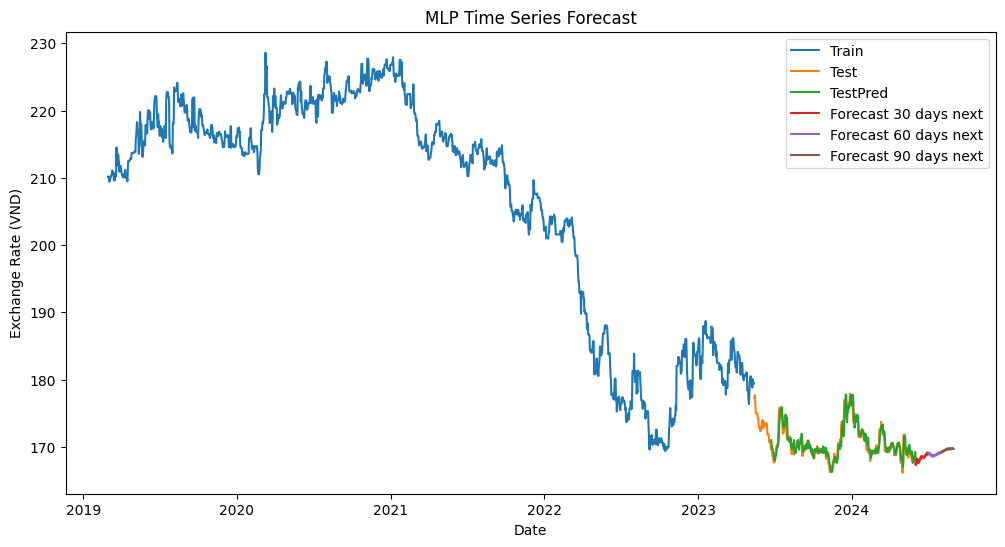

RMSE = 0.962236732863452
MAPE(%) = 0.3951379987544855
MAE = 0.6757455497564271


In [25]:
implement_MLP(train_jpy_2_sc, test_jpy_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[0.01315769]
41
1 day input [0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01315769]
1 day output [[0.00877656]]
2 day input [0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.01315769 0.00877656]
2

18 day output [[0.0269641]]
19 day input [0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.01315769 0.00877656 0.01947737
 0.02208262 0.02035353 0.02214075 0.02239967 0.02176224 0.01791853
 0.02220134 0.02400713 0.02725625 0.0277144  0.02288482 0.02797716
 0.03016655 0.0305962  0.02741407 0.0269641 ]
19 day output [[0.0297758]]
20 day input [0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.01315769 0.00877656 0.01947737 0.02208262
 0.02035353 0.02214075 0.02239967 0.02176224 0.01791853 0.02220134
 0.02400713 0.02725625 0.0277144  0.02288482 0.02797716 0.03016655
 0.0305962  0.02741407 0.0269641  0.0297758 ]
20 day output [[0.0265319

35 day output [[0.03092487]]
36 day input [0.02466368 0.02722614 0.02017937 0.02017937 0.01315769 0.00877656
 0.01947737 0.02208262 0.02035353 0.02214075 0.02239967 0.02176224
 0.01791853 0.02220134 0.02400713 0.02725625 0.0277144  0.02288482
 0.02797716 0.03016655 0.0305962  0.02741407 0.0269641  0.0297758
 0.02653199 0.02653593 0.02917625 0.02937997 0.03044672 0.02712349
 0.03015939 0.02993482 0.02778241 0.02827461 0.03057251 0.03362127
 0.03042295 0.02883412 0.03069722 0.03092487]
36 day output [[0.03280177]]
37 day input [0.02722614 0.02017937 0.02017937 0.01315769 0.00877656 0.01947737
 0.02208262 0.02035353 0.02214075 0.02239967 0.02176224 0.01791853
 0.02220134 0.02400713 0.02725625 0.0277144  0.02288482 0.02797716
 0.03016655 0.0305962  0.02741407 0.0269641  0.0297758  0.02653199
 0.02653593 0.02917625 0.02937997 0.03044672 0.02712349 0.03015939
 0.02993482 0.02778241 0.02827461 0.03057251 0.03362127 0.03042295
 0.02883412 0.03069722 0.03092487 0.03280177]
37 day output [[0.030

53 day output [[0.03598847]]
54 day input [0.02797716 0.03016655 0.0305962  0.02741407 0.0269641  0.0297758
 0.02653199 0.02653593 0.02917625 0.02937997 0.03044672 0.02712349
 0.03015939 0.02993482 0.02778241 0.02827461 0.03057251 0.03362127
 0.03042295 0.02883412 0.03069722 0.03092487 0.03280177 0.03040188
 0.03305298 0.03442723 0.03233074 0.03251234 0.03325283 0.03657699
 0.03543457 0.03346809 0.03514462 0.03559553 0.037013   0.03491041
 0.03580308 0.0385622  0.03657002 0.03598847]
54 day output [[0.03568386]]
55 day input [0.03016655 0.0305962  0.02741407 0.0269641  0.0297758  0.02653199
 0.02653593 0.02917625 0.02937997 0.03044672 0.02712349 0.03015939
 0.02993482 0.02778241 0.02827461 0.03057251 0.03362127 0.03042295
 0.02883412 0.03069722 0.03092487 0.03280177 0.03040188 0.03305298
 0.03442723 0.03233074 0.03251234 0.03325283 0.03657699 0.03543457
 0.03346809 0.03514462 0.03559553 0.037013   0.03491041 0.03580308
 0.0385622  0.03657002 0.03598847 0.03568386]
55 day output [[0.038

71 day output [[0.04108519]]
72 day input [0.03042295 0.02883412 0.03069722 0.03092487 0.03280177 0.03040188
 0.03305298 0.03442723 0.03233074 0.03251234 0.03325283 0.03657699
 0.03543457 0.03346809 0.03514462 0.03559553 0.037013   0.03491041
 0.03580308 0.0385622  0.03657002 0.03598847 0.03568386 0.03842271
 0.037823   0.03597707 0.03840739 0.03900142 0.03872101 0.0370347
 0.03746213 0.04081386 0.03922463 0.0386367  0.03848578 0.04024371
 0.04047681 0.03843739 0.04018554 0.04108519]
72 day output [[0.04100098]]
73 day input [0.02883412 0.03069722 0.03092487 0.03280177 0.03040188 0.03305298
 0.03442723 0.03233074 0.03251234 0.03325283 0.03657699 0.03543457
 0.03346809 0.03514462 0.03559553 0.037013   0.03491041 0.03580308
 0.0385622  0.03657002 0.03598847 0.03568386 0.03842271 0.037823
 0.03597707 0.03840739 0.03900142 0.03872101 0.0370347  0.03746213
 0.04081386 0.03922463 0.0386367  0.03848578 0.04024371 0.04047681
 0.03843739 0.04018554 0.04108519 0.04100098]
73 day output [[0.03989

89 day output [[0.04260483]]
90 day input [0.03580308 0.0385622  0.03657002 0.03598847 0.03568386 0.03842271
 0.037823   0.03597707 0.03840739 0.03900142 0.03872101 0.0370347
 0.03746213 0.04081386 0.03922463 0.0386367  0.03848578 0.04024371
 0.04047681 0.03843739 0.04018554 0.04108519 0.04100098 0.03989048
 0.03934059 0.04233384 0.04165486 0.04079925 0.04085845 0.04217387
 0.04310521 0.04065528 0.04163384 0.04320902 0.04331453 0.04245204
 0.04164381 0.04421499 0.0439884  0.04260483]
90 day output [[0.04322221]]


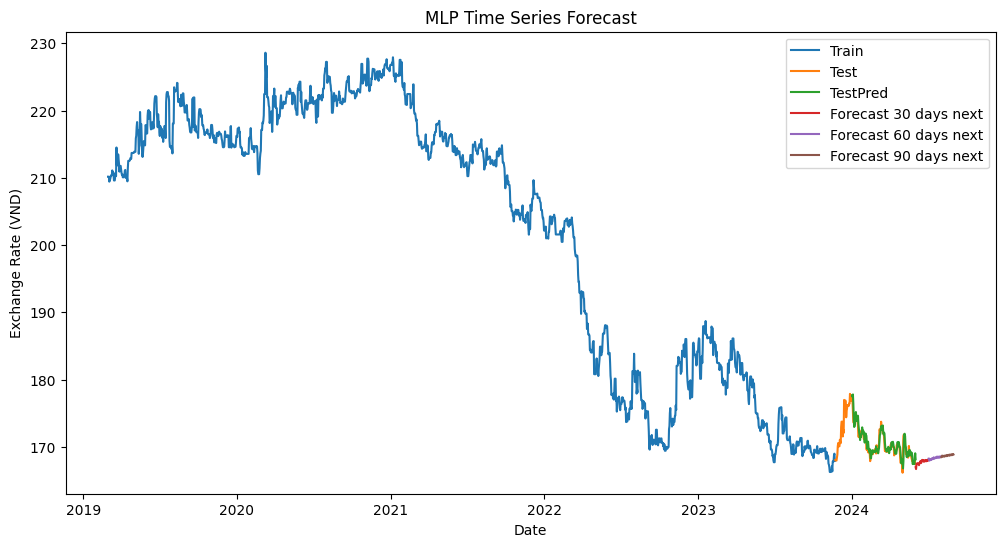

RMSE = 0.8671675388694404
MAPE(%) = 0.364394380709677
MAE = 0.6215135674727597


In [26]:
implement_MLP(train_jpy_3_sc, test_jpy_3_sc)